In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

''' 
REAL DATA 

'''

# sdf = pd.read_csv("./data/stations.csv")
# idf= pd.read_csv("./data/incidents_new.csv")
# idf['IncidentID'] = idf['incident_id']
# # cov_in = pd.read_csv("./logs/incidents_11197_stations_40_trucks_100000/incident_report.csv")
# # sim_in = pd.read_csv("./logs/incidents_11197_stations_40_trucks_1/incident_report.csv")
# # cov_station = pd.read_csv("./logs/incidents_11197_stations_40_trucks_100000/station_report.csv")
# # sim_station = pd.read_csv("./logs/incidents_11197_stations_40_trucks_1/station_report.csv")


'''
UNIT TESTS DATA

'''

# sdf = pd.read_csv("./data/unit_tests/incidents_20_stations_3/stations.csv")
# idf= pd.read_csv("./data/unit_tests/incidents_20_stations_3/incidents.csv")
# idf['IncidentID'] = idf['incident_id']
# # cov_in = pd.read_csv("./logs/incidents_20_stations_3_trucks_10000/incident_report.csv")
# # sim_in = pd.read_csv("./logs/incidents_20_stations_3_trucks_1/incident_report.csv")
# # cov_station = pd.read_csv("./logs/incidents_20_stations_3_trucks_10000/station_report.csv")
# # sim_station = pd.read_csv("./logs/incidents_20_stations_3_trucks_1/station_report.csv")




# cov = pd.merge(cov_station, sdf[["StationID", "Facility Name"]], on="StationID", how="left")
# sim = pd.merge(sim_station, sdf[["StationID", "Facility Name"]], on="StationID", how="left")    
# cov = pd.merge(cov_in, idf[["IncidentID", "incident_level"]], on="IncidentID", how="left")
# sim = pd.merge(sim_in, idf[["IncidentID", "incident_level"]], on="IncidentID", how="left")

,IncidentIndex,IncidentID,Reported,Responded,Resolved,EngineCount,Zone,Status,incident_level
0,0,0,2022-01-01 00:58:14,2022-01-01 00:59:14,2022-01-01 01:58:44,1,329,hasBeenResolved,Low
1,1,1,2022-01-01 01:28:03,2022-01-01 01:29:03,2022-01-01 02:28:33,1,303,hasBeenResolved,Low
2,2,2,2022-01-01 01:42:19,2022-01-01 01:43:19,2022-01-01 02:42:49,1,303,hasBeenResolved,Low
3,3,3,2022-01-01 02:40:00,2022-01-01 02:41:00,2022-01-01 04:10:30,2,151,hasBeenResolved,Moderate
4,4,4,2022-01-01 03:20:38,2022-01-01 03:21:38,2022-01-01 04:21:08,1,303,hasBeenResolved,Low
...,...,...,...,...,...,...,...,...,...
11192,11192,11197,2025-06-21 21:53:56,2025-06-21 21:54:56,2025-06-22 00:24:26,3,146,hasBeenResolved,High
11193,11193,11198,2025-06-22 14:06:46,2025-06-22 14:07:46,2025-06-22 16:37:16,3,145,hasBeenResolved,High
11194,11194,11199,2025-06-23 00:31:33,2025-06-23 00:32:33,2025-06-23 01:32:03,1,181,hasBeenResolved,Low
11195,11195,11200,2025-06-23 13:39:27,2025-06-23 13:40:27,2025-06-23 14:39:57,1,238,hasBeenResolved,Low


In [98]:
merged=pd.merge(cov,sim, on="IncidentID", how="inner", suffixes=('_cov', '_sim'))


In [ ]:
merged=pd.merge(cov,sim, on="IncidentID", how="inner", suffixes=('_cov', '_sim'))
merged['diff']=(pd.to_datetime(merged['Responded_sim']) - pd.to_datetime(merged['Responded_cov'])).dt.total_seconds()
merged['diff'].describe()

count    11197.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: diff, dtype: float64

In [2]:
import pandas as pd
import os

def load_data(test_type: str = 'real'):
    """
    Load station & incident master tables.
    
    Params:
      test_type: 'real' (production data) or 'unit' (unit‐tests data)
      
    Returns:
      sdf: stations DataFrame
      idf: incidents DataFrame (with IncidentID column)
    """


    if test_type == 'real':
        sdf_path = "./data/stations.csv"
        idf_path = "./data/incidents_new.csv"
    elif test_type == 'real_old':
        sdf_path = "./data/stations.csv"
        idf_path = "./data/old_incidents_2022_2024.csv"

    elif test_type == 'unit':

        sdf_path = "./data/unit_tests/incidents_20_stations_3/stations.csv"
        idf_path = "./data/unit_tests/incidents_20_stations_3/incidents.csv"
    else:
        raise ValueError("test_type must be 'real' or 'unit'")
    
    sdf = pd.read_csv(sdf_path)
    idf = pd.read_csv(idf_path)
    # ensure IncidentID exists
    if 'IncidentID' not in idf.columns:
        idf['IncidentID'] = idf['incident_id']
    return sdf, idf


def load_report(
    test_type: str = 'real',
    report_class: str = 'incident',
    scenario: str = 'cov'
):
    """
    Load and merge one report.
    
    Params:
      test_type: 'real' or 'unit'
      report_class: 'incident' or 'station'
      scenario: 'cov' (coverage run) or 'sim' (single‐truck sim)
    
    Returns:
      report DataFrame with the joined metadata (levels or names).
    """
    sdf, idf = load_data(test_type)
    
    # choose base path
    if test_type == 'real':
        base = "./logs/incidents_11197_stations_40_trucks_"
    elif test_type == 'real_old':
        base = "./logs/incidents_324993_stations_40_trucks_"
    else:
        base = "./logs/incidents_20_stations_3_trucks_"
    
    # map scenario to folder suffix
    suffix = '100000' if scenario == 'cov' else '2'
    folder = base + suffix
    
    if report_class == 'incident':
        path = os.path.join(folder, "incident_report.csv")
        df = pd.read_csv(path)
        df = df.merge(
            idf[['IncidentID', 'incident_level']],
            on='IncidentID', how='left'
        )
    elif report_class == 'station':
        path = os.path.join(folder, "station_report.csv")
        df = pd.read_csv(path)
        df = df.merge(
            sdf[['StationID', 'Facility Name']],
            on='StationID', how='left'
        )
    else:
        raise ValueError("report_class must be 'incident' or 'station'")
    
    return df

In [6]:
sdf,idf = load_data('real_old')
cov_inc = load_report('real_old', report_class='incident', scenario='cov')

sim_inc = load_report('real_old', report_class='incident', scenario='sim')

cov_station = load_report('real_old', report_class='station', scenario='cov')


sim_station = load_report('real_old', report_class='station', scenario='sim')




In [10]:
cov_station = pd.merge(cov_station, sdf[["StationID", "Facility Name"]], on="StationID", how="left")
sim_station = pd.merge(sim_station, sdf[["StationID", "Facility Name"]], on="StationID", how="left")    
cov_inc = pd.merge(cov_inc, idf[["IncidentID", "incident_level"]], on="IncidentID", how="left")
sim_inc = pd.merge(sim_inc, idf[["IncidentID", "incident_level"]], on="IncidentID", how="left")

In [11]:
cov_station.TravelTime.mean(), sim_station.TravelTime.mean()

(np.float64(245.19333827359608), np.float64(334.62168530531767))

In [9]:
merged=pd.merge(cov_inc,sim_inc, on="IncidentID", how="inner", suffixes=('_cov', '_sim'))
merged['diff']=(pd.to_datetime(merged['Responded_sim']) - pd.to_datetime(merged['Responded_cov'])).dt.total_seconds()
merged['diff'].describe()

count    324993.000000
mean        243.409387
std        1695.930969
min       -1305.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       83490.000000
Name: diff, dtype: float64

In [64]:
minutes_to_respond_dictionary = { "Low": 60, "Moderate": 90, "High": 150, "Critical": 210 }

cov['minutes_to_respond'] = cov['incident_level'].map(minutes_to_respond_dictionary)
sim['minutes_to_respond'] = sim['incident_level'].map(minutes_to_respond_dictionary)
cov['Responded']=pd.to_datetime(cov['Resolved']) - pd.to_timedelta(cov['minutes_to_respond'], unit='m')
sim['Responded']=pd.to_datetime(sim['Resolved']) - pd.to_timedelta(sim['minutes_to_respond'], unit='m')


In [35]:
check=pd.read_csv("logs/incidents_11197_stations_40_trucks_1/incident_report.csv")

In [39]:
cov

,DispatchTime,StationID,EnginesDispatched,EnginesRemaining,TravelTime,IncidentID,IncidentIndex,Facility Name
0,2022-01-01 00:59:14,2,2,9998,221.3,0,0,Station 04
1,2022-01-01 01:09:14,2,2,9996,221.3,1,1,Station 04
2,2022-01-01 01:19:14,2,2,9994,221.3,2,2,Station 04
3,2022-01-01 01:29:14,2,2,9992,221.3,3,3,Station 04
4,2022-01-01 01:39:14,2,2,9990,221.3,4,4,Station 04
5,2022-01-01 01:49:14,2,2,9988,221.3,5,5,Station 04
6,2022-01-01 01:59:14,2,2,9986,221.3,6,6,Station 04
7,2022-01-01 02:09:14,2,2,9984,221.3,7,7,Station 04
8,2022-01-01 02:19:14,2,2,9982,221.3,8,8,Station 04
9,2022-01-01 02:29:14,2,2,9980,221.3,9,9,Station 04


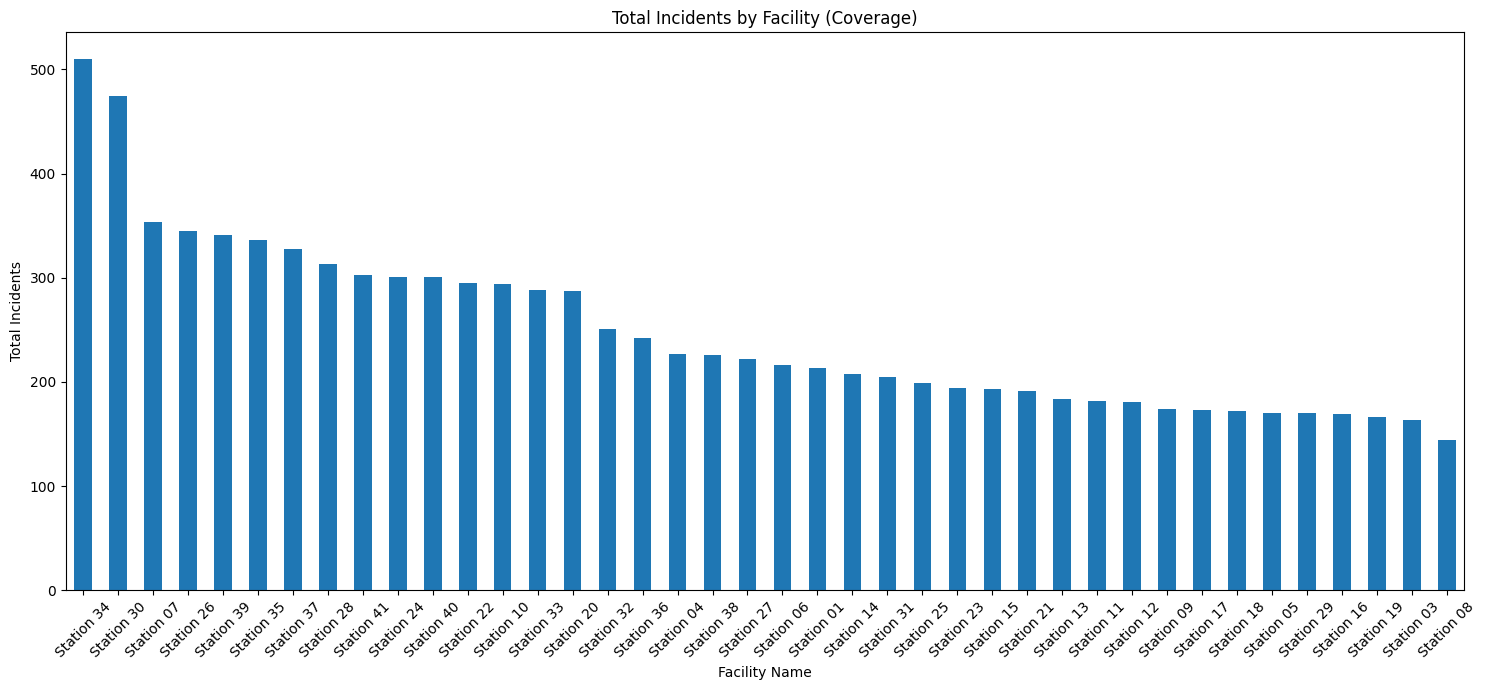

In [19]:
cov.groupby("Facility Name")["TravelTime"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))
plt.title("Total Incidents by Facility (Coverage)")
plt.xlabel("Facility Name")
plt.ylabel("Total Incidents")
plt.xticks(rotation=45)
plt.tight_layout()



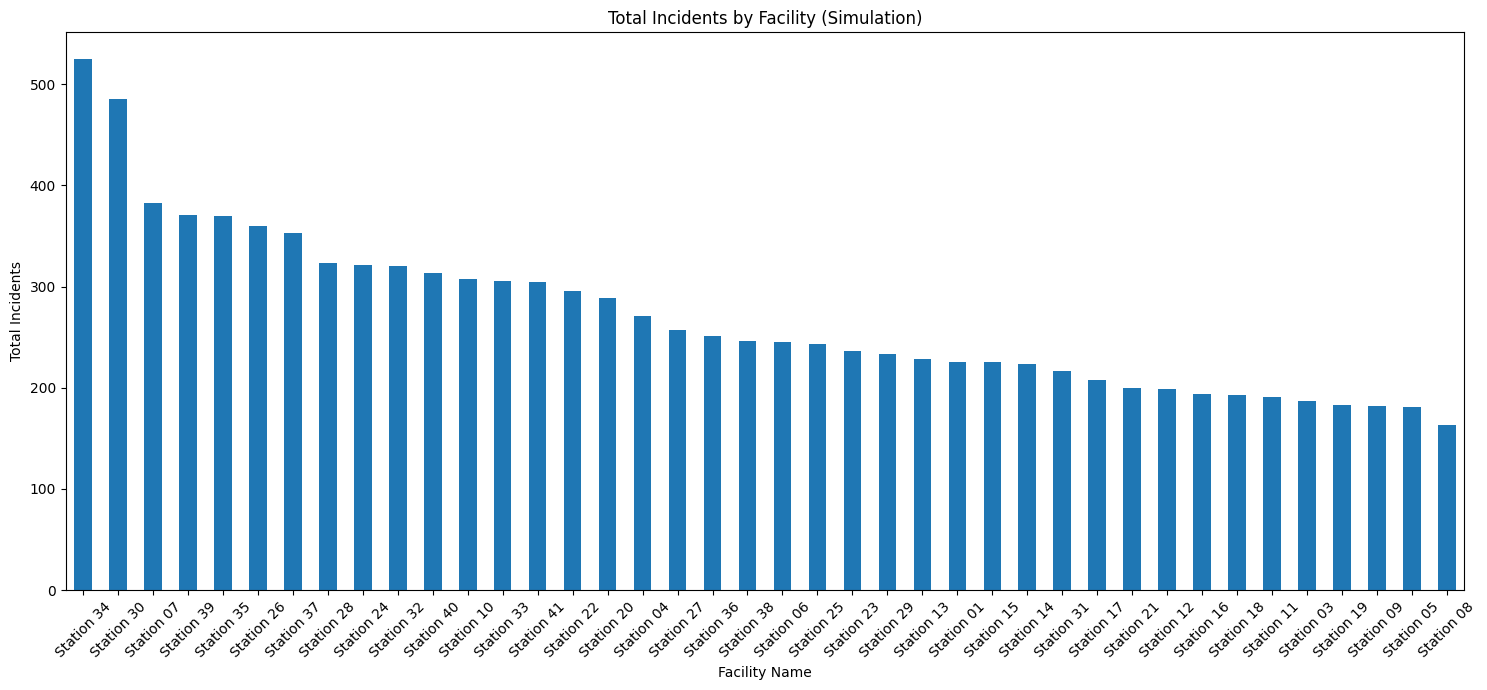

In [20]:
sim.groupby("Facility Name")["TravelTime"].mean().sort_values(ascending=False).plot(kind='bar', figsize=(15, 7))
plt.title("Total Incidents by Facility (Simulation)")
plt.xlabel("Facility Name")
plt.ylabel("Total Incidents")
plt.xticks(rotation=45)
plt.tight_layout()

In [4]:
duplicate_incidents = sim[sim.duplicated(subset=['IncidentID'], keep=False)]
missed=duplicate_incidents.groupby('IncidentID').first().groupby('Facility Name').size().reset_index(name='Count')

In [5]:
len(sim)-missed.Count.sum()

np.int64(11197)

In [6]:
duplicate_incidents = sim[sim.duplicated(subset=['IncidentID'], keep=False)]

In [7]:
duplicate_incidents = sim[sim.duplicated(subset=['IncidentID'], keep='first')]

In [81]:
len(sim)-len(duplicate_incidents)

5219

In [8]:
duplicate_incidents[duplicate_incidents.duplicated(subset=['IncidentID'], keep=False)]

,DispatchTime,StationID,EnginesDispatched,EnginesRemaining,TravelTime,IncidentID,IncidentIndex,Facility Name


In [10]:
#add the missing facilities
missing_facilities = set(sdf['Facility Name']) - set(missed['Facility Name'])
for facility in missing_facilities:
    missed = missed.append({'Facility Name': facility, 'Count': 0}, ignore_index=True)  


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Prepare the data ---
# station_summary has columns: StationID, TotalIncidents, TravelTimes (a list)
# Explode the travel‐time lists into long form for seaborn
df_box = (
    station_summary
    .loc[:, ['Facility Name','TravelTimes']]
    .explode('TravelTimes')
    .rename(columns={'TravelTimes':'TravelTime'})
)
df_box['TravelTime'] = df_box['TravelTime'].astype(float)

# Compute overall mean & median
overall_mean   = df_box['TravelTime'].mean()
overall_median = df_box['TravelTime'].median()

# --- Plot ---
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(14, 10),
    gridspec_kw={'height_ratios':[3,1]},
    sharex=True
)

# 1) Boxplot panel
sns.boxplot(
    x='Facility Name', y='TravelTime',
    data=df_box,
    ax=ax1,
    color="skyblue",
    fliersize=4
)
ax1.axhline(320,   ls='--', color='red',   label='Accepatable Travel Time')
ax1.axhline(240, ls='--', color='green', label='Desirable Travel Time')
ax1.set_title("Travel Time by Station (seconds)", fontsize=16)
ax1.set_ylabel("Seconds", fontsize=14)
ax1.set_ylim(0, 3000)
ax1.set_yticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000])
ax1.legend()

# 2) Barplot panel
sns.barplot(
    x='Facility Name', y='TotalIncidents',
    data=station_summary,
    ax=ax2,
    color="salmon"
)
ax2.set_title("Incident Counts per Station", fontsize=16)
ax2.set_ylabel("Number of Incidents", fontsize=14)
ax2.set_xlabel("")  # hide the x‐label; we'll use ticklabels
ax2.set_ylim(0, 800)
ax2.set_yticks([0,200,400,600,800])
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

(np.float64(212.61330583562483), np.float64(235.3716346153846))

In [79]:
# Prepare data
missed = missed.sort_values(by='Facility Name')
coverage_counts = cov['Facility Name'].value_counts().sort_index()
simulator_counts = sim['Facility Name'].value_counts().sort_index()

# Ensure all have the same index order
all_facilities = sorted(set(coverage_counts.index).union(simulator_counts.index).union(missed['Facility Name']))
coverage_counts = coverage_counts.reindex(all_facilities, fill_value=0)
simulator_counts = simulator_counts.reindex(all_facilities, fill_value=0)
missed_counts = missed.set_index('Facility Name').reindex(all_facilities, fill_value=0)['Count']

x = np.arange(len(all_facilities))

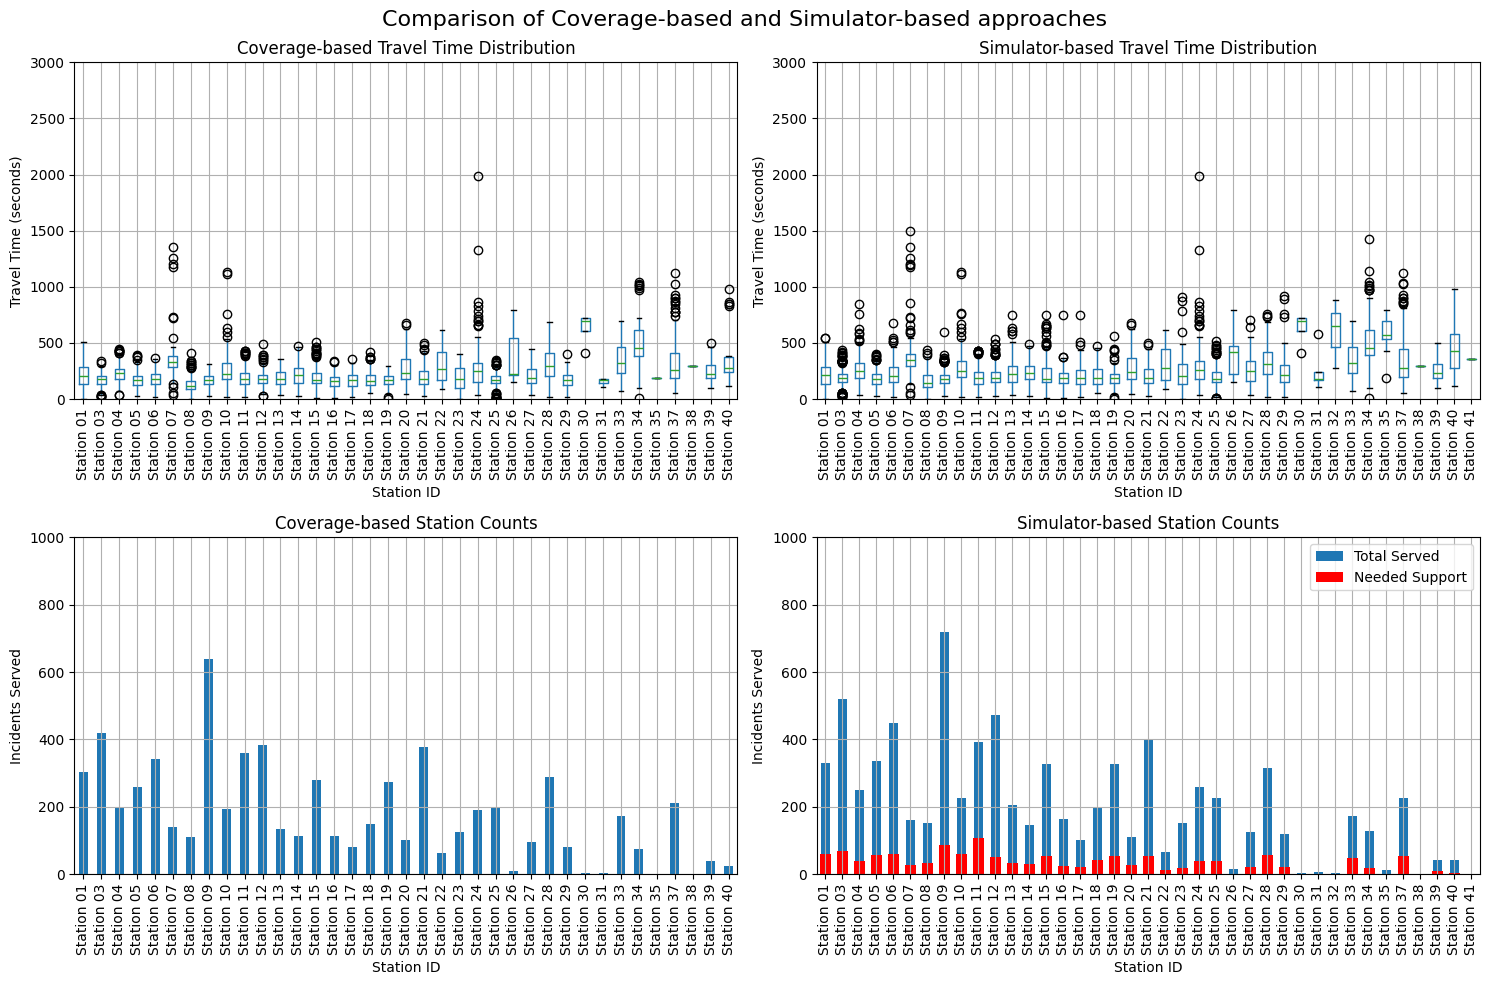

In [80]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
axs = np.array(axs)
axs = axs.reshape(-1)


# Convert to using ax[0] and ax[1] for subplots
cov.boxplot(column='TravelTime', by='Facility Name', ax=axs[0], rot=90)
axs[0].set_title('Coverage-based Travel Time Distribution')
axs[0].set_xlabel('Station ID')
axs[0].set_ylabel('Travel Time (seconds)')

sim.boxplot(column='TravelTime', by='Facility Name', ax=axs[1], rot=90)
axs[1].set_title('Simulator-based Travel Time Distribution')
axs[1].set_xlabel('Station ID')
axs[1].set_ylabel('Travel Time (seconds)')

axs[0].set_ylim(0, 3000)
axs[1].set_ylim(0, 3000)


coverage_counts = cov['Facility Name'].value_counts().sort_index()
simulator_counts = sim['Facility Name'].value_counts().sort_index()

coverage_counts.plot(kind='bar', ax=axs[2])
axs[2].set_title('Coverage-based Station Counts')
axs[2].set_xlabel('Station ID')
axs[2].set_ylabel('Incidents Served')
axs[2].set_xticklabels(coverage_counts.index, rotation=90)

simulator_counts.plot(kind='bar', ax=axs[3])
axs[3].bar(x, missed_counts, width=0.6, label='Needed Support', color='red', alpha=1)
axs[3].set_title('Simulator-based Station Counts')
axs[3].set_xlabel('Station ID')
axs[3].set_ylabel('Incidents Served')
axs[3].set_xticklabels(simulator_counts.index, rotation=90)
axs[3].legend(['Total Served', 'Needed Support'], loc='upper right')

axs[2].set_ylim(0, 1000)
axs[3].set_ylim(0, 1000)

axs[2].grid(axis='y')
axs[3].grid(axis='y')
axs[2].grid(axis='x')
axs[3].grid(axis='x')
plt.suptitle('Comparison of Coverage-based and Simulator-based approaches', fontsize=16)
plt.tight_layout()
plt.savefig("dist.png", dpi=300)


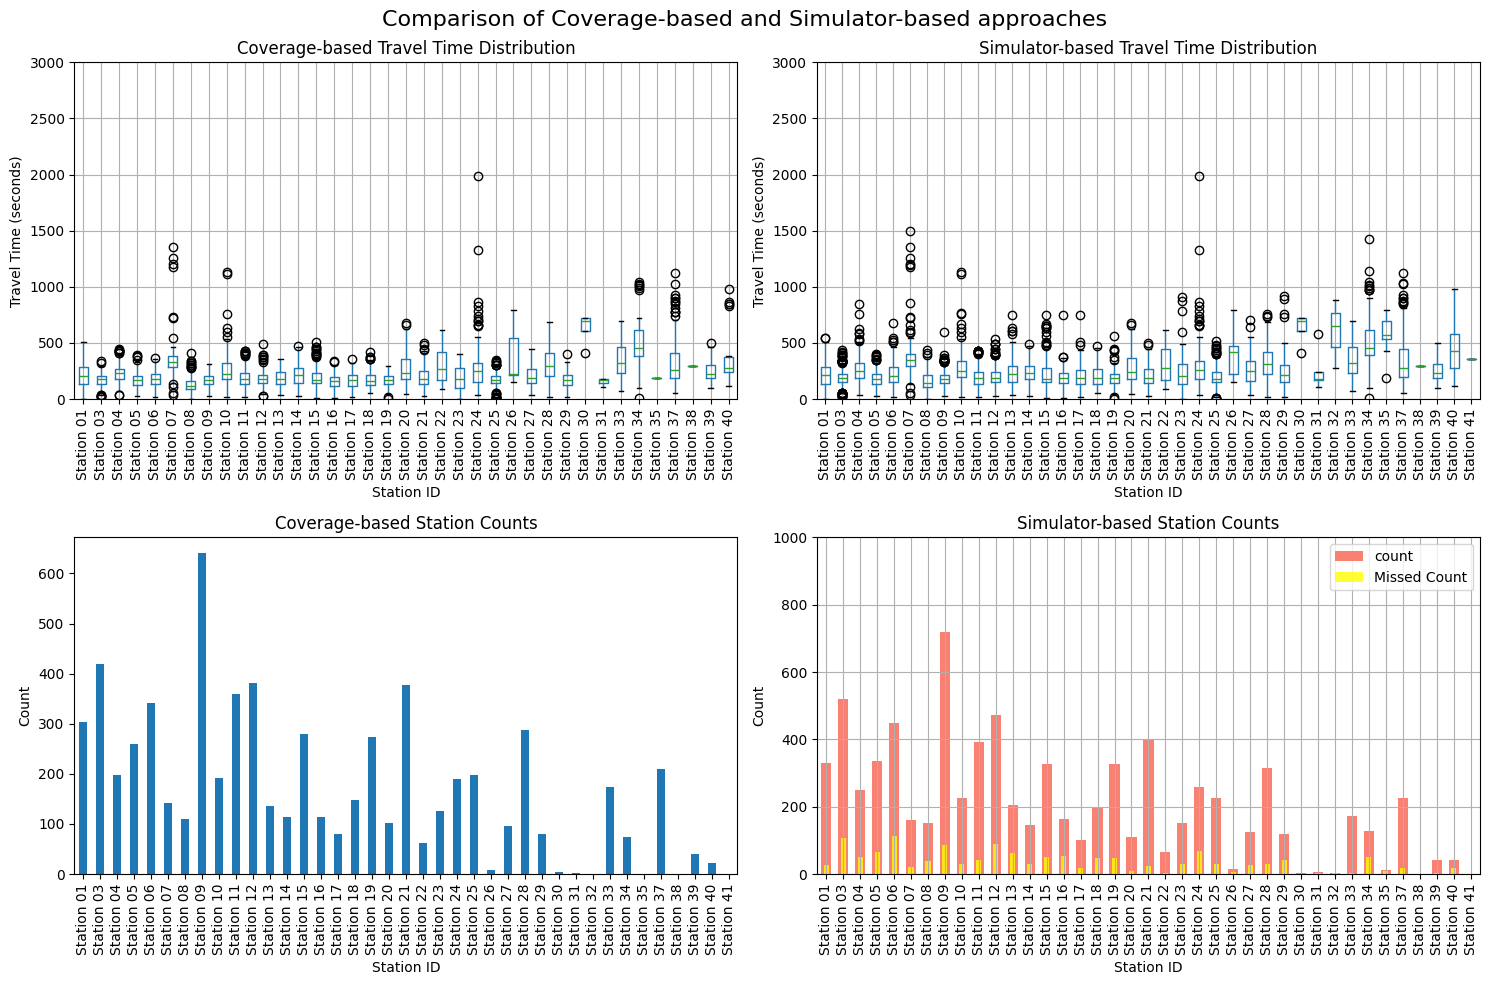

In [39]:
# Prepare data
missed = missed.sort_values(by='Facility Name')
coverage_counts = cov['Facility Name'].value_counts().sort_index()
simulator_counts = sim['Facility Name'].value_counts().sort_index()

# Ensure all have the same index order
all_facilities = sorted(set(coverage_counts.index).union(simulator_counts.index).union(missed['Facility Name']))
coverage_counts = coverage_counts.reindex(all_facilities, fill_value=0)
simulator_counts = simulator_counts.reindex(all_facilities, fill_value=0)
missed_counts = missed.set_index('Facility Name').reindex(all_facilities, fill_value=0)['Count']

x = np.arange(len(all_facilities))

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))
axs = np.array(axs).reshape(-1)

# Boxplots (top row)
cov.boxplot(column='TravelTime', by='Facility Name', ax=axs[0], rot=90)
axs[0].set_title('Coverage-based Travel Time Distribution')
axs[0].set_xlabel('Station ID')
axs[0].set_ylabel('Travel Time (seconds)')
axs[0].set_ylim(0, 3000)

sim.boxplot(column='TravelTime', by='Facility Name', ax=axs[1], rot=90)
axs[1].set_title('Simulator-based Travel Time Distribution')
axs[1].set_xlabel('Station ID')
axs[1].set_ylabel('Travel Time (seconds)')
axs[1].set_ylim(0, 3000)

# Bottom left: Missed and actual counts (overlayed bars)
coverage_counts.plot(kind='bar', ax=axs[2])
axs[2].set_title('Coverage-based Station Counts')
axs[2].set_xlabel('Station ID')
axs[2].set_ylabel('Count')
axs[2].set_xticklabels(coverage_counts.index, rotation=90)

# Bottom right: Simulator-based counts
simulator_counts.plot(kind='bar', width=0.6, ax=axs[3], color='salmon')
axs[3].bar(x, missed_counts, width=0.3, label='Missed Count', color='yellow', alpha=0.8)
axs[3].set_title('Simulator-based Station Counts')
axs[3].set_xlabel('Station ID')
axs[3].set_ylabel('Count')
axs[3].set_xticklabels(simulator_counts.index, rotation=90)
axs[3].set_ylim(0, 1000)
axs[3].grid(axis='y')
axs[3].grid(axis='x')
axs[3].legend()

plt.suptitle('Comparison of Coverage-based and Simulator-based approaches', fontsize=16)
plt.tight_layout()

In [ ]:
## Number of times a fire station was not able to meet the demand of an incident
## Given that each station only has 2 fire trucks

In [40]:
missed

,Facility Name,Count
0,Station 01,26
1,Station 03,106
2,Station 04,51
3,Station 05,67
4,Station 06,113
5,Station 07,20
6,Station 08,40
7,Station 09,86
8,Station 10,30
9,Station 11,41


In [ ]:
# Count the number of duplicate IncidentID entries (excluding the first occurrence)
num_duplicates = sim.duplicated(subset=['IncidentID']).sum()
print(f"Number of duplicate IncidentID entries: {num_duplicates}")

Number of duplicate IncidentID entries: 1358


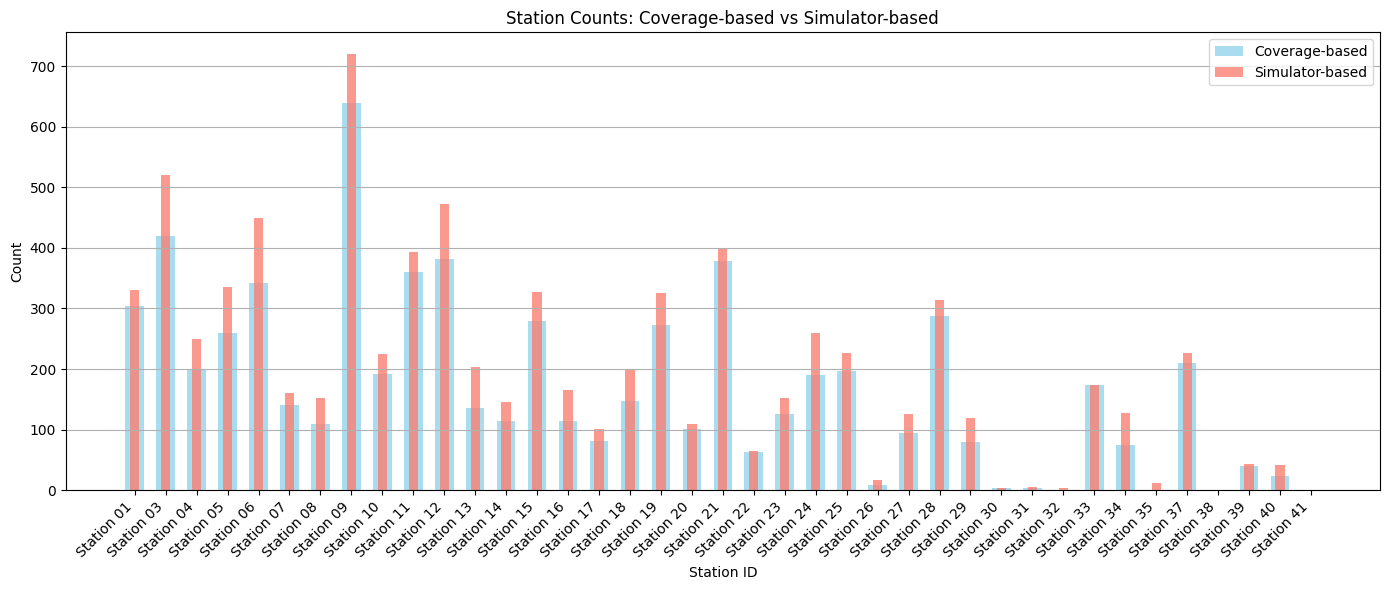

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
missed
simulator_counts = sim['Facility Name'].value_counts().sort_index()

# Ensure both have the same index order
all_facilities = sorted(set(coverage_counts.index).union(simulator_counts.index))
coverage_counts = coverage_counts.reindex(all_facilities, fill_value=0)
simulator_counts = simulator_counts.reindex(all_facilities, fill_value=0)

x = np.arange(len(all_facilities))

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x, coverage_counts, width=0.6, label='Coverage-based', color='skyblue', alpha=0.7)
ax.bar(x, simulator_counts, width=0.3, label='Simulator-based', color='salmon', alpha=0.8)

ax.set_xlabel('Station ID')
ax.set_ylabel('Count')
ax.set_title('Station Counts: Coverage-based vs Simulator-based')
ax.set_xticks(x)
ax.set_xticklabels(all_facilities, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()